# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: `33`
* Students: `Yuxuan Long Mingbo Cui, Shengzhao Lei, Futong Liu, Yuxuan Long` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [2]:
word_num = 1433
word_attributes = ['word' + str(i) for i in range(word_num)]
column_list = ['paper_id'] + word_attributes + ['class_label']
pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names = column_list) 
pd_content.head()

,paper_id,word0,word1,word2,word3,word4,word5,word6,word7,word8,...,word1424,word1425,word1426,word1427,word1428,word1429,word1430,word1431,word1432,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [3]:
pd_content['class_label'].value_counts()  ### modify

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [4]:
my_field = pd_content['class_label'][4]
features = pd_content[pd_content['class_label'] == my_field]
features = features[word_attributes].to_numpy()
print('the field '+my_field + ' has feature vectors with shape',features.shape)

the field Probabilistic_Methods has feature vectors with shape (426, 1433)


Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [5]:
my_paper_num = features.shape[0]
distance = [np.sqrt(np.sum((features[i] - features) ** 2, axis = 1)) for i in range(my_paper_num)]
distance = np.array(distance)
dimention = distance.shape[0] # this is the dimention of the matrix 
print(distance.shape)

(426, 426)


Check the mean pairwise distance $\mathbb{E}[D]$.

In [6]:
mean_distance = distance.mean()
mean_distance

5.790575729028696

Plot an histogram of the euclidean distances.

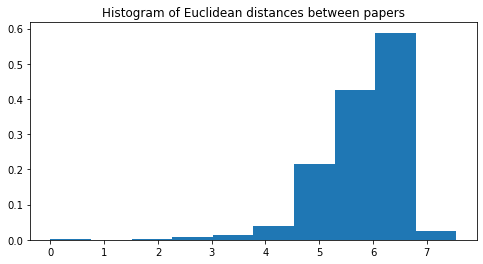

In [7]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten(),density=True);  

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [8]:
threshold = mean_distance
A_feature = distance + np.eye(my_paper_num) * threshold # always ensure that the diagonal element is zero
A_feature = (A_feature < threshold).astype(int)

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [9]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')
num_cite = cora_cites.shape[0]
all_paper_id = pd_content['paper_id']
total_paper_num = len(all_paper_id)
A_citation = np.zeros((total_paper_num, total_paper_num))
dic = dict(zip(all_paper_id, range(total_paper_num)))  # 这步太好了吧

for i in range(num_cite):
    cite = cora_cites[i]
    A_citation[dic[cite[1]], dic[cite[0]]] = 1
    A_citation[dic[cite[0]], dic[cite[1]]] = 1
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [10]:
mask = (pd_content['class_label'] != my_field).to_numpy()
A_citation = np.delete(A_citation, np.arange(total_paper_num)[mask], axis = 0)
A_citation = np.delete(A_citation, np.arange(total_paper_num)[mask], axis = 1)
print(A_citation.shape)

(426, 426)


Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [11]:
np.count_nonzero(A_citation - A_citation.transpose())

0

Check the shape of your adjacency matrix again.

In [12]:
print(A_citation.shape)
print(A_feature.shape)

(426, 426)
(426, 426)


### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [13]:
num_edges_feature = A_feature.sum() / 2 
num_edges_citation = A_citation.sum()/ 2 
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 34695.0
Number of edges in the citation graph: 660.0


Plot the degree distribution histogram for each of the graphs.

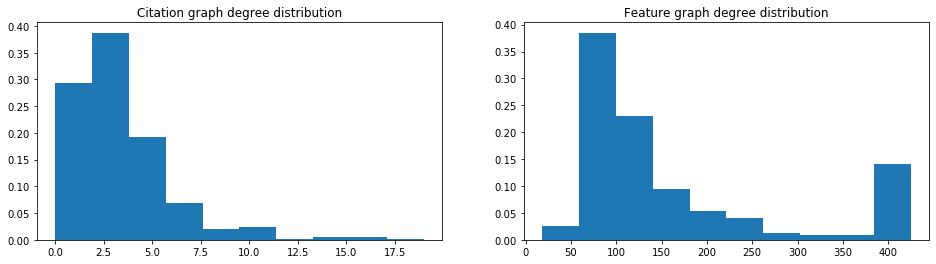

In [14]:
degrees_citation = np.sum(A_citation, axis = 1) 
degrees_feature = np.sum(A_feature, axis = 1) 

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization);

Calculate the first and second moments of the degree distribution of each graph.

In [15]:
cit_moment_1 = np.mean(degrees_citation) 
cit_moment_2 = np.mean(degrees_citation ** 2) 

feat_moment_1 = np.mean(degrees_feature) 
feat_moment_2 = np.mean(degrees_feature ** 2) 

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 3.0985915492957745
2nd moment of citation graph: 16.6056338028169
1st moment of feature graph: 162.88732394366198
2nd moment of feature graph: 40686.17840375587


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.



**Your answer here:**

1.The moments demonstrate the average magnitude of degrees with some order. And the feature graph has obviously `larger moment` than citation graph, since from the distributions we can see that **feature graph has numerous nodes with much higher degree**.]

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

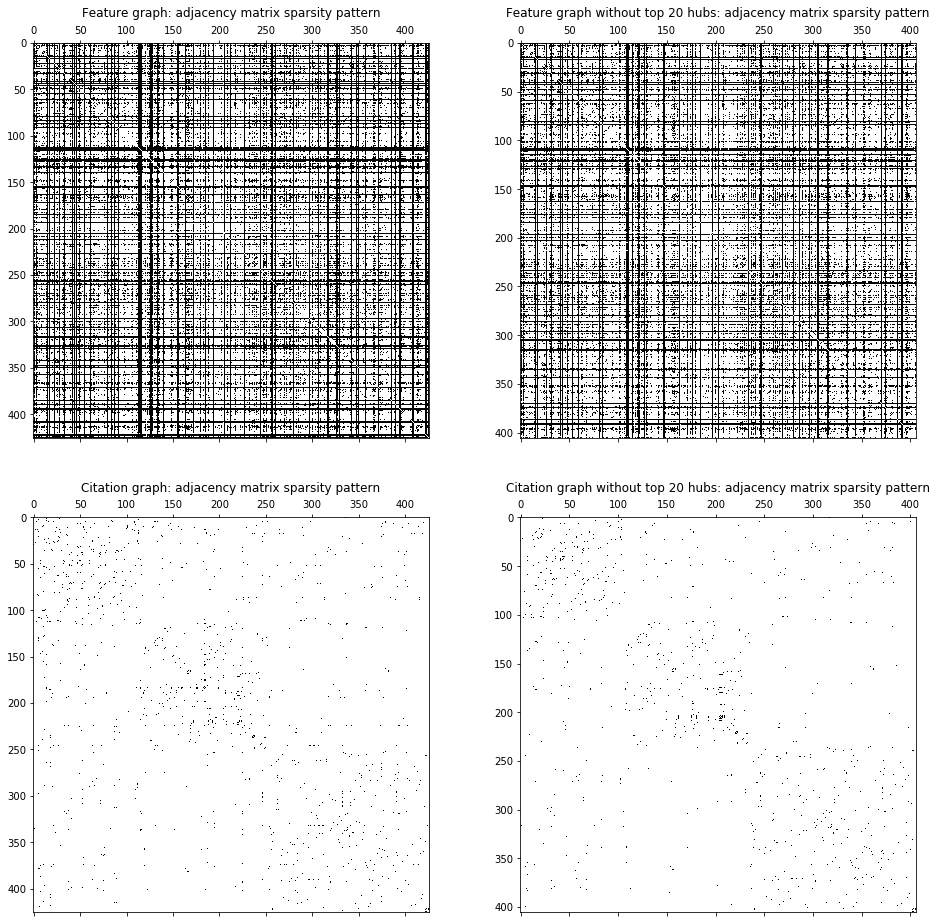

In [16]:
index_feature = np.argsort(degrees_feature)[-20:]
index_citation = np.argsort(degrees_citation)[-20:]
reduced_A_feature = np.delete(A_feature, index_feature, axis = 1)
reduced_A_feature = np.delete(reduced_A_feature, index_feature, axis = 0)
reduced_A_citation = np.delete(A_citation, index_citation, axis = 1) 
reduced_A_citation = np.delete(reduced_A_citation, index_citation, axis = 0)
### simple test
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

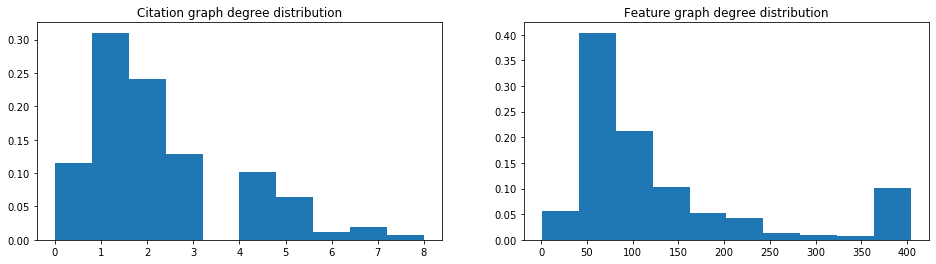

In [17]:
## modify
reduced_degrees_feat = np.sum(reduced_A_feature, axis = 1) 
reduced_degrees_cit = np.sum(reduced_A_citation, axis = 1) 

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [18]:
reduced_cit_moment_1 = np.mean(reduced_degrees_cit) 
reduced_cit_moment_2 = np.mean(reduced_degrees_cit ** 2) 

reduced_feat_moment_1 = np.mean(reduced_degrees_feat) 
reduced_feat_moment_2 = np.mean(reduced_degrees_feat ** 2)

print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 2.1724137931034484
Citation graph second moment: 7.527093596059113
Feature graph first moment:  129.99014778325125
Feature graph second moment:  28199.5960591133


Print the number of edges in the reduced graphs.

In [19]:
print('The number of edges in feature graph is ', reduced_A_feature.sum() / 2)
print('The number of edges in citation graph is ', reduced_A_citation.sum() / 2)

###examine the percentage changes for each moment
print('Percentage change in first moment of citation graph is ', (cit_moment_1 - reduced_cit_moment_1) / cit_moment_1)
print('Percentage change in second moment of citation graph is ', (cit_moment_2 - reduced_cit_moment_2) / cit_moment_2)
print('Percentage change in first moment of feature graph is ', (feat_moment_1 - reduced_feat_moment_1) / feat_moment_1)
print('Percentage change in second moment of feature graph is ', (feat_moment_2 - reduced_feat_moment_2) / feat_moment_2)

The number of edges in feature graph is  26388.0
The number of edges in citation graph is  441.0
Percentage change in first moment of citation graph is  0.29890282131661433
Percentage change in second moment of citation graph is  0.5467144653772713
Percentage change in first moment of feature graph is  0.20196277625500753
Percentage change in second moment of feature graph is  0.3068998572618433


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

**Your answer here:**

1. The effect of removing the hubs is **different**.   
2. The **second moment** is affected the most since it is more **sensitive to high degrees**. And the effect on citation graph is **greater than** feature graph in both moments since the feature graph is much **denser** than the citation graph, meanwhile there are still many hubs left in the feature graph after removing those biggest hubs.

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [20]:
def measure_diff(threshold,distance,num_edges_citation):
    A_feature_pruned = distance + np.eye(my_paper_num) * threshold # always ensure that the diagonal element is zero
    A_feature_pruned = (A_feature_pruned < threshold).astype(int)
    num_edges_feature_pruned = A_feature_pruned.sum() / 2
    diff = num_edges_feature_pruned-num_edges_citation
    return diff

In [21]:
diff = 100
start = 0
end = 6 
while abs(diff) >=100:
    threshold = (start+end)/2
    diff =  measure_diff(threshold,distance,num_edges_citation)
    print('the difference is %f, and the threshold is %f'%(diff,threshold))
    if diff<0:
        start = threshold
    elif diff>200:
        end = threshold 

the difference is -155.000000, and the threshold is 3.000000
the difference is 3809.000000, and the threshold is 4.500000
the difference is 1031.000000, and the threshold is 3.750000
the difference is 493.000000, and the threshold is 3.375000
the difference is 268.000000, and the threshold is 3.187500
the difference is 60.000000, and the threshold is 3.093750


In [22]:
A_feature_pruned = distance + np.eye(my_paper_num) * threshold # always ensure that the diagonal element is zero
A_feature_pruned = (A_feature_pruned < threshold).astype(int)
num_edges_feature_pruned = A_feature_pruned.sum() / 2
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 34695.0
Number of edges in the feature graph after pruning: 720.0
Number of edges in the citation graph: 660.0


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

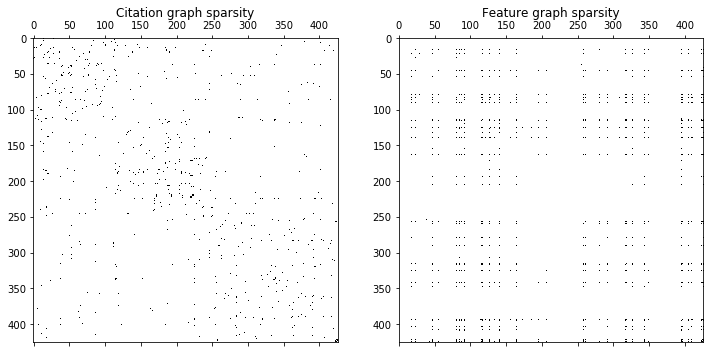

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);


Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [24]:
power_feature = A_feature 
power_citation = A_citation  
path_matrix_citation =  power_citation + np.eye(my_paper_num)
path_matrix_feature =  power_feature + np.eye(my_paper_num)
N = 10
for i in range(N-1):
    power_feature = np.dot(A_feature, power_feature)
    power_citation = np.dot(A_citation, power_citation)
    path_matrix_feature += power_feature
    path_matrix_citation += power_citation
    


Check the sparsity pattern for both of path matrices.

The number of zeros in the path matrix of feature graph:  0
The number of zeros in the path matrix of citation graph:  79088


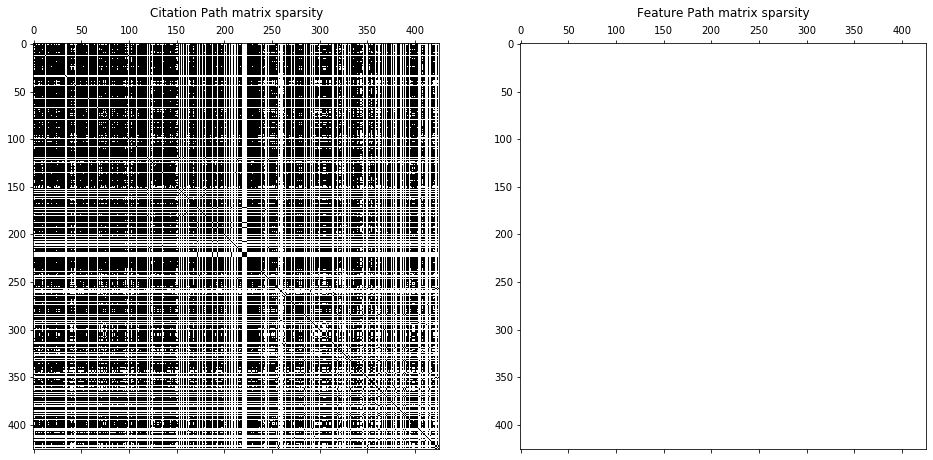

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);
print('The number of zeros in the path matrix of feature graph: ', np.sum(path_matrix_feature == 0))
#### feature graph is connected
print('The number of zeros in the path matrix of citation graph: ', np.sum(path_matrix_citation == 0)) # not connected

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

The number of zeros in the path matrix of pruned feature graph:  177622


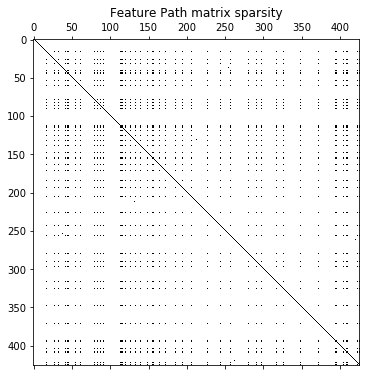

In [26]:
power_feature = A_feature_pruned
path_matrix_pruned = power_feature + np.eye(my_paper_num)
N = 10
for i in range(N - 1):
    power_feature = np.dot(A_feature_pruned, power_feature)
    path_matrix_pruned += power_feature

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);
print('The number of zeros in the path matrix of pruned feature graph: ', np.sum(path_matrix_pruned == 0))

**Your answer here:**

1.The path matrix of the pruned feature graph is much **sparser** than that of the original feature graph.

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** 

2.There exists certain positive integer $N_0$, when $N \geq N_0$, the corresponding path matrix has **no zeros** in it.
The unpruned feature graph is connected.

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:**    
3.The diameter can be found as **smallest number $N$**, with all values in the corresponding path matrix are **non-zeros**.


If any of your graphs is connected, calculate the diameter using that process.

In [27]:
power_feature = A_feature  # modify
path_matrix_feature = np.eye(my_paper_num) + power_feature 
N = 10
for i in range(N - 1):
    if np.count_nonzero(path_matrix_feature) == dimention ** 2:
        break
    power_feature = np.dot(A_feature, power_feature)
    path_matrix_feature += power_feature
    

diameter = i + 1
print(f"The diameter is: {diameter}")

The diameter is: 2


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [28]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [29]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [30]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 426, Number of edges: 660
Number of self-loops: 0, Number of connected components: 48


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [31]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 426, Number of edges: 720
Number of self-loops: 0, Number of connected components: 365


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [32]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

426

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [33]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
print(G_citation.size()) # number of edges
m

660


690.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:**
As $\langle k \rangle = p (n - 1)$ and $\langle k \rangle \approx 2 m / n$, then we have $p \approx \frac {2 m}{ n (n - 1)}$.

In [34]:
p = m * 2 / (n * (n - 1)) ##  ???
print(p)
G_er = nx.erdos_renyi_graph(n, p)

0.007622203811101905


Check the number of edges in the Erdős–Rényi graph.

In [35]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 661 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:**
The preferential attachment parameter can be approximated as probability that the new node connects to node i depends on 
$ P_{i} = \frac {k_{i}}{\displaystyle\sum_{j}k_{j}}$

In [36]:
q = 2   ### pay attention ...... 
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [37]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 848 edges.


### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [38]:
giant_citation = max(nx.connected_component_subgraphs(G_citation), key=len)
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 333 nodes and 582 edges.


In [39]:
giant_feature = max(nx.connected_component_subgraphs(G_feature), key=len) 
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 59 nodes and 717 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [40]:
giant_er = max(nx.connected_component_subgraphs(G_er), key=len) 
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 407 nodes and 659 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**
We have the probability $u$ for a node not being in the giant node, then $u = (1 - p + pu)^{n - 1}$. Re-organizing this equation gives $p = (u^{\frac{1}{n-1}} - 1)/(u - 1)$.

In [43]:
u = 1 - giant_feature.number_of_nodes() / n
p_new = ((u ** (1 / (n - 1))) - 1) / (u - 1) 
print(p_new)
G_er_new = nx.erdos_renyi_graph(n, p_new)

0.0025322383786828585


Check the size of the new Erdős–Rényi network and its giant component.

In [46]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = max(nx.connected_component_subgraphs(G_er_new), key=len)
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

My new Erdos Renyi network that simulates the citation graph has 222 edges.
The giant component of the new Erdos-Rényi network has 36 nodes and 35 edges.


### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

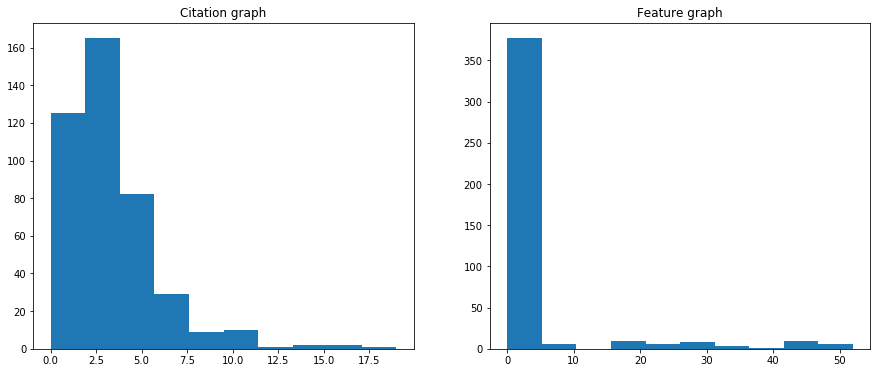

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = [G_citation.degree(i) for i in range(n)] 
axes[0].hist(citation_degrees);
axes[1].set_title('Feature graph')
feature_degrees = [G_feature.degree(i) for i in range(n)] 
axes[1].hist(feature_degrees);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:**   
Both degree distributions show that the most degrees are in the range between 0 and 5. However, there are some nodes having much higher degrees, which may not follow a Poissnon distribution. Therefore, we may predict that both graphs indicate scale-free networks.

Now, plot the degree distribution historgrams for the simulated networks.

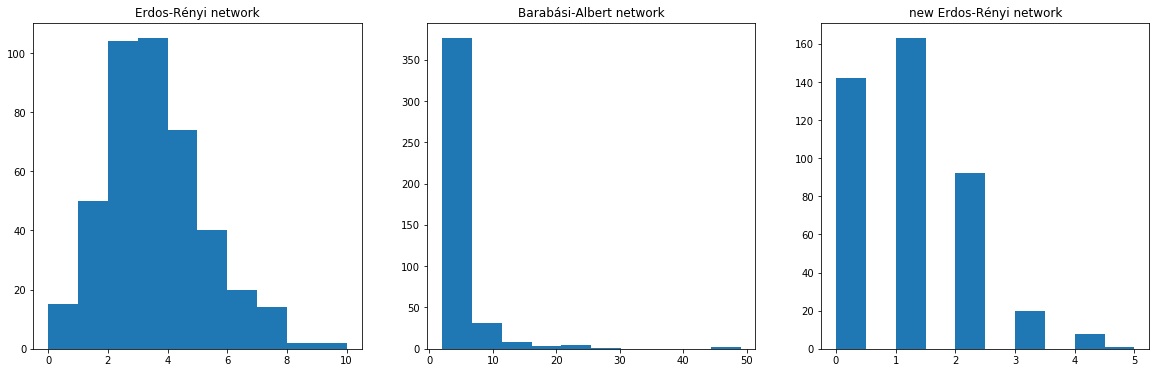

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = [G_er.degree(i) for i in range(n)]
axes[0].hist(er_degrees);
axes[1].set_title('Barabási-Albert network')
ba_degrees = [G_ba.degree(i) for i in range(n)]
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = [G_er_new.degree(i) for i in range(n)]
axes[2].hist(er_new_degrees);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:**   
1.Yes,**Barabási-Albert network** is the best match for **feature graph** in terms of degree distribution.   
2.**Erdos-Rényi network** is the best network matched within three networks for **citation graph**.

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [51]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 426 nodes and 720 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:**    
No. Function `configuration_model` generates a random pseudograph by randomly assigning edges to match the given degree sequence. Identical number of nodes and edges does not imply that the individual information of the nodes are identical. For example, the geometric properties may be different, i.e. connections between nodes, which can imply different clustering coefficients.

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [52]:
nx.average_clustering(G_citation)

0.2402694603120846

In [53]:
nx.average_clustering(G_feature)

0.10990779169766017

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:**  
The clustering coefficient indicates the average density of links in the neighbourhood. The clustering coefficient of citation graph is higher than the other. This may mean that citation graph can be a smaller 'world', that it is easier to evolve towards a dense graph.

Now, let us check the average clustering coefficient for the simulated networks.

In [60]:
nx.average_clustering(G_er)

0.0051773604590506

In [61]:
nx.average_clustering(G_ba)

0.06034495912461713

In [62]:
nx.average_clustering(nx.Graph(G_config))

0.05737646875979106

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**  
The clustering coefficient of Barabási-Albert network is very similar to feature graph. Erdos-Rényi network has a much smaller clustering coefficient, since it is common for random network having a small clustering coefficient. The clustering coefficients of the citation and feature graphs are relatively smaller than the simulated networks. 

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**  
I expect that Havel-Hakimi graph generator would give a good match, since it models a **simple graph** but other graph generators seem to generate random graphs or directed graphs which are not desired.

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

Clustering coefficient for the feature graph is  0.10990779169766017
Clustering coefficient for the new feature graph is  0.10908190948957629
Clustering coefficient for the citation graph is  0.2402694603120846
Clustering coefficient for the new citation graph is  0.49867249990489415
The number of edges of feature graph is  720
The number of edges of new feature graph is  720
The number of edges of citation graph is  660
The number of edges of new citation graph is  660


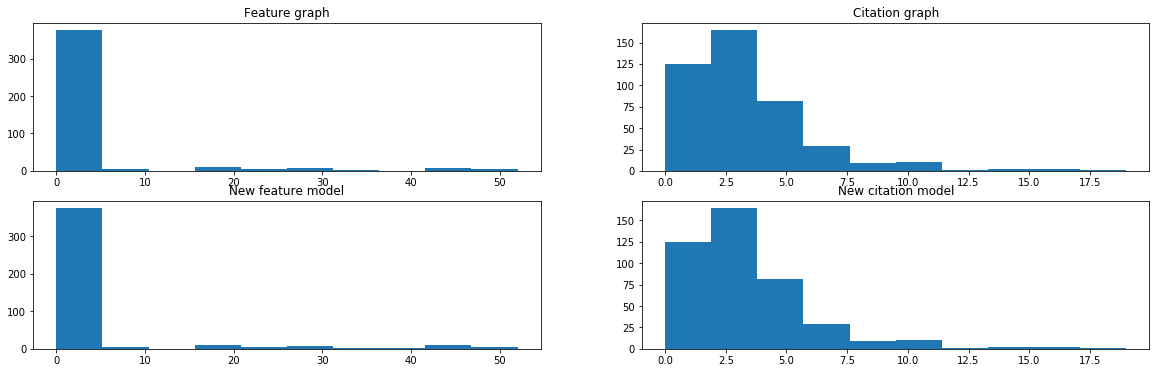

In [63]:

# G_new_feat = nx.expected_degree_graph(feature_degrees,  selfloops= False)
# G_new_cit = nx.expected_degree_graph(citation_degrees,  selfloops= False)
G_new_feat = nx.havel_hakimi_graph(feature_degrees)
G_new_cit = nx.havel_hakimi_graph(citation_degrees)

fig, axes = plt.subplots(2, 2, figsize=(20, 6))

axes[0, 0].set_title('Feature graph')
axes[0, 0].hist(feature_degrees);

axes[0, 1].set_title('Citation graph')
axes[0, 1].hist(citation_degrees);

axes[1, 0].set_title('New feature model')
axes[1, 0].hist([G_new_feat.degree(i) for i in range(n)]);

axes[1, 1].set_title('New citation model')
axes[1, 1].hist([G_new_cit.degree(i) for i in range(n)]);


print('Clustering coefficient for the feature graph is ', nx.average_clustering(G_feature))
print('Clustering coefficient for the new feature graph is ', nx.average_clustering(G_new_feat))
print('Clustering coefficient for the citation graph is ', nx.average_clustering(G_citation))
print('Clustering coefficient for the new citation graph is ', nx.average_clustering(G_new_cit))


print('The number of edges of feature graph is ', G_feature.size())
print('The number of edges of new feature graph is ', G_new_feat.size())
print('The number of edges of citation graph is ', G_citation.size())
print('The number of edges of new citation graph is ', G_new_cit.size())


Comment on the similarities of your match.

**Your answer here:**  
When using Havel-Hakimi algorithm to simulate the feature graph, the **clustering coefficients** are almost the same, which means high similarity. The **degree distribution** is almost the same as seen from the histogram and the number of edges, which means that this newly generated graph highly matches with the feature graph.

Regarding the citation graph, the generated graph using the degree sequence seems to have identical degree distribution as citation graph. However, the clustering coefficients are not that similar.